# Problem

I used to be an actuary so my financial future is of big concern to me. I was recently really disappointed in the return of my investments and felt somewhat powerless because I don't know much about investing. I know about how much I'm going to need for my retirement, but not the details of how to get there. Being an hands-on guy I figured I could use this Project 5 opportunity to learn more about finance and see if my knowledge of machine learning can help me save on commission and make better decisions on my own. Understanding what has a significant impact on one's life is important not only to me but to everyone. If I can help those around me, my wife, my family and my friends with their investments decisions why not take a shot at it. 

The goal is not to have an automated system for trading. It is not my intention to deal with High Frequency Trading but rather provide a prediction to a human to help with financial decisions.

# Solution

This is a **regression** problem. I want to know what will be the return of an investment in the future. What will be the return over a certain period of time so I can issue a Buy or Sell order. This is not about building a diverse portfolio but rather a tool to help build it. Building the portfolio will be the next step after this project.

This could be a classification problem if I was trying to issue a Buy or Sell order, but here I want to output the return value and not an action. A Buy order would be when the direction is up (positive return) and a Sell order is the opposite. 

The predictions will need to be as precise as possible. Underestimating or overestimating the return of a stock will necessarily mean that the Buy/Sell decisions won't be as informed as possible. It will of course not be possible to be 100% accurate, but I think that within 5% is good enough. So if the true return is 10% then if I predict between 9.5% and 10.5% the algorithm is good enough. I don't expect such precision if the prediction is too far in the future. The further it is in the future, the less certain our predictions will be. So 5% for a 7 day forecast is my goal.


### Approach

- Two algorithms will be mainly expolored, support vector regression (SVR) and kNN.
    - I expect the returns (the object of our prediction) to be somewhat chaotic given the features I will use. kNN is a good choice for that
    - SVR is also very adaptable because of its kernel trick so it could adapt to this anticipated chaotic landscape.
- Training and testing set size will be 70/30 split in time. The testing set will be after the training set so we are not peeking into the future when training
- GridSearch will be used with Mean Squared Error (MSE) as a minimization metric. I want the model to fit as best as possible the large values of stock price changes
- Bagging will be used as well because it is less prone to overfitting. It will take the mean of every model so the overfitting will be smoothed out.
- The speed requirements for training is not that great for the current problem. I am not dealing in High Frequency Trading. A human will take a short (few days) to mid (few weeks) term decision based on the predictions.

#### High level implementation details
- The Stock object is initialized with a ticker and a period over which to calculate the return. By default it's 7 days. 
- The raw data (open, high, low, close, volume) is rescaled by dividing by their respective max values. These max values are kepts around for later transformation so the rescaling is always done the same way.
- The we can call get_data to have the examples and the targets. The examples are augmented with all the features mentioned below.
- Each predictors, SVR and kNN, have a fit and transform method to mimic the librairies provided by Scikit-learn. The fit methods split the fitting data in two sets 80/20 for cross-validation purpose. The CV set is used to select the best fit model trained over a grid of parameters.

#### Features

Many features could be interesting such as P/E Ratio and Ebitda, but those informations only come out every quarter and I'm looking at features than changes at least every day. I confered with a technical trader (one that looks at indicators to inform him on what decision to take) on what he uses in his everyday life, like the following:
- Raw features that composes every stock
    - Volume
    - Adjusted Close
    - Adjusted High
    - Adjusted Low
    - Adjusted Open

- Derived features can also be obtained based on the raw data (above)
    - 10 day rolling mean and 
    - 10 day rolling standard deviation (for the [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands))
    - S&P500 index
    - Price Volume Oscillator (PVO)
    - Ratio of Exponential Mean Average (EMA) of 10, 25 and 50 days over EMA of 100 days
    - Kama
    - Relative Strength Index (RSI)
    - Ichimoku Cloud which is composed of many indicators: tenkansen, kijunsen, senkouA, senkouB, chikou
    - Chandelier which has two indicators: Highest High and Lowest Low over the last 22 days
    - Average True Ratio

Most of these indicators come from this website
http://stockcharts.com/school/doku.php?%20%20%20%20id=chart_school:technical_indicators

#### Target
- Return over X days $\left(\frac{price_{t+x}}{price_{t}} - 1\right)$

#### Data Source
- Quandl API
- Yahoo Finance

### Package Requirements
- numpy:           1.10.2
- pandas:          0.17.1
- python-dateutil: 2.4.2
- pytz:            2015.7
- quandl:          2.8.9
- requests:        2.9.0
- six:             1.10.0
- scikit-learn:    0.17
- scipy:           0.16.1

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from predictor import SVRPredictor, Stock, KNNPredictor, AdaBoostPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Data exploration

Let's first explore the raw data that we can get from a financial API

In [5]:
from stockAPI import QuandlAPI

In [7]:
data = QuandlAPI.get_data('AAPL', '2014-01-01', '2015-10-31', 160, 15)

In [8]:
data.head()

,Open,High,Low,Close,Volume,Adjusted Close
Date,,,,,,
2013-07-25,440.699993,441.400009,435.810001,438.499996,57373400,59.580371
2013-07-26,435.300003,441.040001,434.340008,440.990013,50038100,59.918697
2013-07-29,440.799995,449.990005,440.200008,447.790009,62014400,60.842634
2013-07-30,449.959991,457.150009,449.229988,453.320015,77355600,61.594013
2013-07-31,454.990013,457.339973,449.429993,452.529984,80739400,61.486669


#### Data preprocessing
##### Adjusting prices

Adjusted Close as defined by [Investopedia](http://www.investopedia.com/terms/a/adjusted_closing_price.asp) is: 
> A stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time prior to the next day's open. The adjusted closing price is often used when examining historical returns or performing a detailed analysis on historical returns.

It is a very convenient column that is provided that takes into account all the splits and dividends that happened in the past. So for a example if a stock trades at 100\$ and splits 2:1 (every action is split in two), then the price will drop to 50\$ and that's not because the price tanked. So the Adusted Close go back in time to normalize all the prices based on all the information we have today.

Just from that we see that Open, High and Low are all higher than Adjusted Close. That's because they are not naturally adjusted like the Adjusted Close column. So I do it manually in the data preprocessing by taking the ratio between the Close and the Adjusted Close and apply that ratio to Open, High and Low.

In [11]:
ratio = data['Adjusted Close'] / data['Close']
data['High'] = data['High']*ratio
data['Low'] = data['Low']*ratio
data['Open'] = data['Open']*ratio

In [12]:
desc = data.describe()
desc

,Open,High,Low,Close,Volume,Adjusted Close
count,583.000000,583.000000,583.000000,583.000000,5.830000e+02,583.000000
mean,97.391303,98.249295,96.476897,270.012212,6.388849e+07,97.367840
std,21.669206,21.847367,21.388966,203.746050,3.016379e+07,21.609351
min,59.145577,59.925489,59.015140,90.279999,1.447960e+07,59.580371
25%,74.665381,75.162767,74.052302,111.454998,4.454560e+07,74.592033
50%,98.330957,99.309959,97.332371,126.559998,5.717930e+07,98.634445
75%,116.142848,117.161050,114.920193,517.654999,7.471310e+07,115.958640
max,132.729176,132.808133,130.250359,647.349983,2.663808e+08,131.380384


There is nothing to adjust for volume even though we are dealing with stock splits. For example, Apple split 7:1, so the number of shares on the market was multiplied by 7. This is a raw value, an absolute number of things that do exists. It cannot be adjusted and normalize the way it is done for price because that would make shares disappear. A split also does not mean that more volume will be traded.

##### Rescaling

All the technical indicators vary more or less between -1 and 1 (irregardless of the following rescaling) so I rescale all the raw data between 0 and 1 as well. I did not use Z-score scaling as it will create negative prices which doesn't make sense. So I just divide all the values by the max. So, for example, Open is rescaled by the maximum Open value in the training dataset.

In order to keep the same rescaling I keep those max values around to I can rescale the prediction set the same way. The values will possibly be higher than 1 which is okay as long as it stays rescaled within range of everything else.

#### Outliers
I don't expect any outliers in the data. Although prices are quite volatile, they more or less stay within range. On the other hand volume can vary a lot. For example, AAPL on Septembre 28th of 2000 more than 1.8 billions shares were traded where it usually stays under 0.6 billions. Volumes could be problematic.

We will define the outliers to be below and above 1.5 times the interquartile range.

In [21]:
# Interquartile range
iqr = desc.ix['75%'] - desc.ix['25%']
iqr

Open                    41.477467
High                    41.998284
Low                     40.867891
Close                  406.200001
Volume            30167500.000000
Adjusted Close          41.366607
dtype: float64

In [20]:
# Are the values above the lower bracket
(desc.ix['50%'] - 1.5*iqr) <= desc.ix['min']

Open              True
High              True
Low               True
Close             True
Volume            True
Adjusted Close    True
dtype: bool

In [19]:
# Are the values below the higher bracket
(desc.ix['50%'] + 1.5*iqr) >= desc.ix['max'] 

Open               True
High               True
Low                True
Close              True
Volume            False
Adjusted Close     True
dtype: bool

As expected there is at least one value that is above the higher bracket. Some technical indicators are based on the volume so I will filter those out. The only filtering that I could do for the outliers would be on volume because as I mentioned above the price, although volatile, will not spike like this. But even though I don't expect any outliers on price I will still filter based on the IQR because I cannot explore every stock out there to confirm my hypothesis.

All the other features are based on these raw data, so there is no need to do filter for those.

In [38]:
stock = Stock('AAPL')
data, label = stock.get_data(start_date='2014-01-01', end_date='2015-10-31', fit=True)
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,462,0.780591,0.141198,0.513235,0.677246,0.810286,0.912501,1.000000
High,462,0.787056,0.142191,0.519508,0.680052,0.824441,0.922393,1.000000
Low,462,0.787841,0.141911,0.521281,0.684525,0.818678,0.922287,1.000000
Volume,462,0.221872,0.099392,0.054357,0.158087,0.198127,0.259259,1.000000
Adjusted Close,462,0.788453,0.142113,0.523321,0.683531,0.817923,0.922064,1.000000
SP Close,462,0.933825,0.044886,0.817474,0.901097,0.936616,0.975725,1.000000
ATR,462,0.009570,0.004180,0.004120,0.006788,0.008981,0.011319,0.027710
r_mean10,462,0.785464,0.142306,0.534134,0.680106,0.823046,0.926017,0.987257
r_std10,462,0.013995,0.007358,0.003368,0.008266,0.012685,0.017493,0.042158
r_high22,462,0.815176,0.149978,0.565249,0.698843,0.853584,0.965655,1.000000


### Training
I created two wrapper classes for SVR and kNN that work pretty much like scikit-learn, i.e. with a *fit* and *predict* methods. It also manages to fetch, preprocess and transform the data. All you have to give it is a list of ticker and a range of dates to train/predict on. One model is calculated per ticker in the list.

#### Grid Search

Both of the classes do a GridSearch for the hyperparameters in the *fit* method and the best one is kept around for  *predict*.

The GridSearch takes the range of dates to train on and split 80/20 for a cross validation set. The search is trained on 80% of the data and validated on 20% with mean squared error as metric.

##### Hyperparameter search for SVR:
- kernel: ['rbf', 'sigmoid', 'linear']
- C: [0.01, 0.1, 1, 10, 100]
- epsilon: [0.0000001, 0.000001, 0.00001]
            
##### Hyperparameter search for kNN:
- n_neighbors: [2, 5, 10, 15]

#### Boosting
AdaBoostRegressor is also used on both classes with the default parameters.

### SVR

> SVR models are fitted over a grid search and boosting. Training time is about 5 minutes but as I mentioned above it is of no big concerns since we are not dealing in high frequency traiding.

#### Pre AdaBoost

Here is the result of the prediction before using AdaBoost. I ran the code without AdaBoost and kept the resulting graphic.

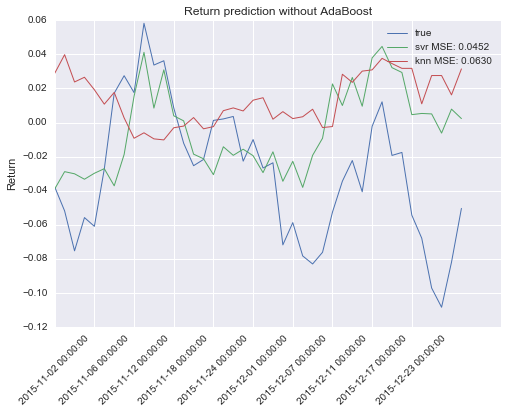

In [13]:
from IPython.display import Image
Image('Without AdaBoost.png')

The Mean Squared Error of SVR is the lowest of the two regressor. Now let's see if we use the ensemble method of AdaBoost to improve the results

#### With AdaBoost

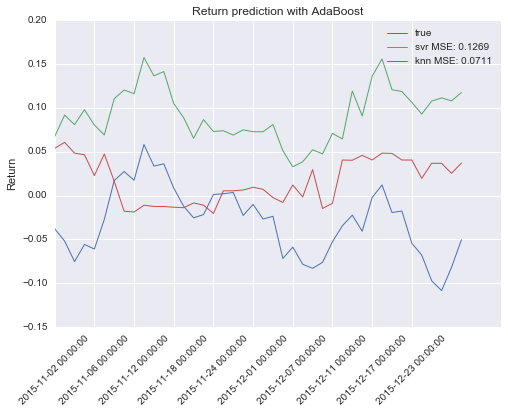

In [44]:
from IPython.display import Image
Image('With AdaBoost.png')

Suprisingly things are worse with AdaBoost, the MSE are higher. Why would that be? Ensemble methods use weak learners such as decision stump and SVR and kNN are strong learners. Perhaps this is making the predictions worse. Let's explore that idea of using AdaBoost with the default estimator, a DecisionTreeRegressor and compare it to SVR and kNN that are not using AdaBoost.

### AdaBoost

There is also a GridSearch done for AdaBoost
##### Hyperparameter search:
- n_estimators: [25, 50, 100]
- learning_rate: [0.01, 0.1, 1, 10]
- loss: ['linear', 'square', 'exponential']

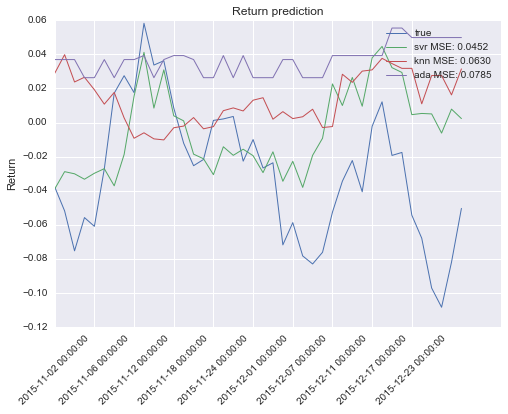

In [21]:
from IPython.display import Image
Image('Only AdaBoost.png')

So the best performing algorithm of all three is the SVR without using the ensemble method of AdaBoost. The MSE is 4.52% which is below what I was aiming for. 

In [22]:
svr = SVRPredictor(['GOOGL'], 7)
knn = KNNPredictor(['GOOGL'], 7)
svr.fit(start_date='2014-01-01', end_date='2015-10-31')
knn.fit(start_date='2014-01-01', end_date='2015-10-31')
ada = AdaBoostPredictor(['GOOGL'], 7)
ada.fit(start_date='2014-01-01', end_date='2015-10-31')

In [23]:
svr.models['GOOGL']

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=1e-05, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [24]:
knn.models['GOOGL']

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform')

In [25]:
ada.models['GOOGL']

AdaBoostRegressor(base_estimator=None, learning_rate=10, loss='exponential',
         n_estimators=100, random_state=None)

In [26]:
predictions_svr = svr.transform(['GOOGL'], start_date='2015-11-01', end_date='2015-12-31')
predictions_knn = knn.transform(['GOOGL'], start_date='2015-11-01', end_date='2015-12-31')
predictions_ada = ada.transform(['GOOGL'], start_date='2015-11-01', end_date='2015-12-31')

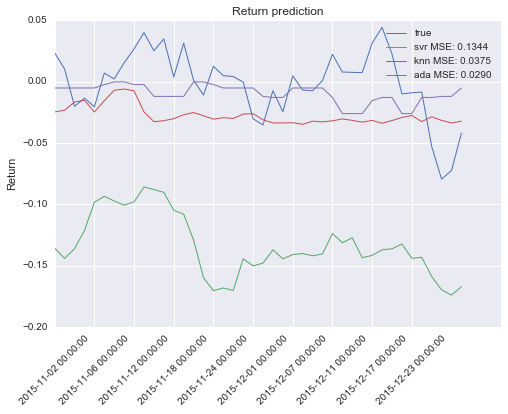

In [27]:
y_pred_svr, y_true = predictions_svr['GOOGL']
y_pred_knn, _ = predictions_knn['GOOGL']
y_pred_ada, _ = predictions_ada['GOOGL']

plt.plot(range(0,len(y_true)), y_true, linewidth=1)
plt.plot(range(0,len(y_pred_svr)), y_pred_svr, linewidth=1)
plt.plot(range(0,len(y_pred_knn)), y_pred_knn, linewidth=1)
plt.plot(range(0,len(y_pred_ada)), y_pred_ada, linewidth=1)
plt.xticks(4*np.arange(len(y_true)/4), y_true.index[::4], rotation=45)

plt.legend([
        'true', 
        'svr MSE: {:.4f}'.format(((y_pred_svr-y_true)**2).mean()**0.5), 
        'knn MSE: {:.4f}'.format(((y_pred_knn-y_true)**2).mean()**0.5),
        'ada MSE: {:.4f}'.format(((y_pred_ada-y_true)**2).mean()**0.5)])
plt.ylabel('Return')
plt.title('Return prediction')

So there is no free lunch. There may not be one model that fits all stocks. SVR that was doing so good on AAPL is now the worse performing model for GOOGL. But looking at the curve SVR still looks like it's following the shape of the true return. Can we do something about it?

### Delta

Now we see that the SVR prediction curve seems to be following the true curve quite well but it's off. It would be tempting to just shift the prediction curve by a certain amount $\delta$ to get really close to the true curve. Eyeballing it we see that they would be a really close match. But the problem resides in this $\delta$. If I were to predict the return tomorrow, I would have no idea how much that $\delta$ should be. I would be blind by not knowing what the true curve is. Whereas now the test set is in the past so I have the luxury of trying to match it by shifting the model predictions.

That being said, as of today at the closing market I know the actual return over the last 7 days period. Wouldn't that true historical curve provide a good starting point for our estimate? Let's try just that. Get the last return over the training period (which obviously need to be in the past) and use that as starting point.

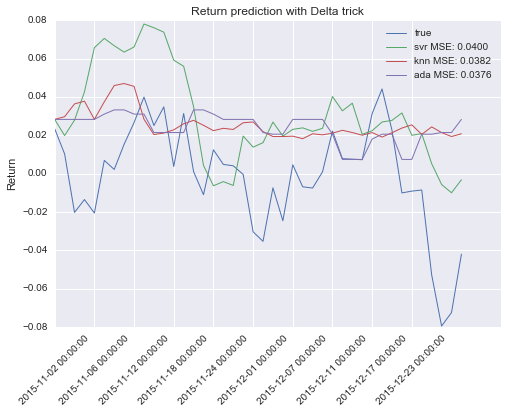

In [30]:
# Get the initial starting point of the training period
stock = Stock('GOOGL')
data, label = stock.get_data(start_date='2014-01-01', end_date='2015-10-31', fit=True)
delta_svr = y_pred_svr.values[0] - label.values[-1]
delta_knn = y_pred_knn.values[0] - label.values[-1]
delta_ada = y_pred_ada.values[0] - label.values[-1]


plt.plot(range(0,len(y_true)), y_true, linewidth=1)
plt.plot(range(0,len(y_pred_svr)), y_pred_svr - delta_svr, linewidth=1)
plt.plot(range(0,len(y_pred_knn)), y_pred_knn - delta_knn, linewidth=1)
plt.plot(range(0,len(y_pred_ada)), y_pred_ada - delta_ada, linewidth=1)
plt.xticks(4*np.arange(len(y_true)/4), y_true.index[::4], rotation=45)

plt.legend([
        'true', 
        'svr MSE: {:.4f}'.format((((y_pred_svr-delta_svr)-y_true)**2).mean()**0.5), 
        'knn MSE: {:.4f}'.format((((y_pred_knn-delta_knn)-y_true)**2).mean()**0.5),
        'ada MSE: {:.4f}'.format((((y_pred_ada-delta_ada)-y_true)**2).mean()**0.5)])
plt.ylabel('Return')
plt.title('Return prediction with Delta trick')


SVR is now not as bad as before and the other two models are still doing good (and better than SVR) on MSE.

In [31]:
svr = SVRPredictor(['AAPL'], 7)
knn = KNNPredictor(['AAPL'], 7)
svr.fit(start_date='2014-01-01', end_date='2015-10-31')
knn.fit(start_date='2014-01-01', end_date='2015-10-31')
ada = AdaBoostPredictor(['AAPL'], 7)
ada.fit(start_date='2014-01-01', end_date='2015-10-31')

In [32]:
predictions_svr = svr.transform(['AAPL'], start_date='2015-11-01', end_date='2015-12-31')
predictions_knn = knn.transform(['AAPL'], start_date='2015-11-01', end_date='2015-12-31')
predictions_ada = ada.transform(['AAPL'], start_date='2015-11-01', end_date='2015-12-31')

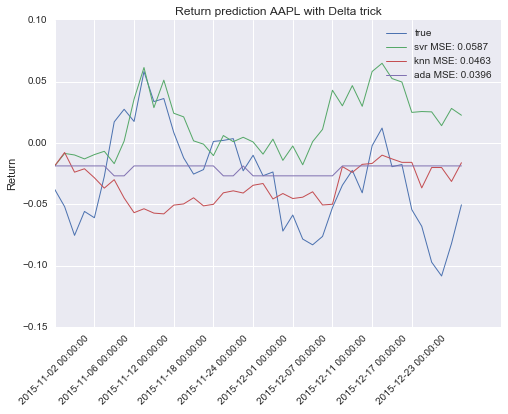

In [34]:
y_pred_svr, y_true = predictions_svr['AAPL']
y_pred_knn, _ = predictions_knn['AAPL']
y_pred_ada, _ = predictions_ada['AAPL']

# Get the initial starting point of the training period
stock = Stock('AAPL')
data, label = stock.get_data(start_date='2014-01-01', end_date='2015-10-31', fit=True)
delta_svr = y_pred_svr.values[0] - label.values[-1]
delta_knn = y_pred_knn.values[0] - label.values[-1]
delta_ada = y_pred_ada.values[0] - label.values[-1]


plt.plot(range(0,len(y_true)), y_true, linewidth=1)
plt.plot(range(0,len(y_pred_svr)), y_pred_svr - delta_svr, linewidth=1)
plt.plot(range(0,len(y_pred_knn)), y_pred_knn - delta_knn, linewidth=1)
plt.plot(range(0,len(y_pred_ada)), y_pred_ada - delta_ada, linewidth=1)
plt.xticks(4*np.arange(len(y_true)/4), y_true.index[::4], rotation=45)

plt.legend([
        'true', 
        'svr MSE: {:.4f}'.format((((y_pred_svr-delta_svr)-y_true)**2).mean()**0.5), 
        'knn MSE: {:.4f}'.format((((y_pred_knn-delta_knn)-y_true)**2).mean()**0.5),
        'ada MSE: {:.4f}'.format((((y_pred_ada-delta_ada)-y_true)**2).mean()**0.5)])
plt.ylabel('Return')
plt.title('Return prediction AAPL with Delta trick')


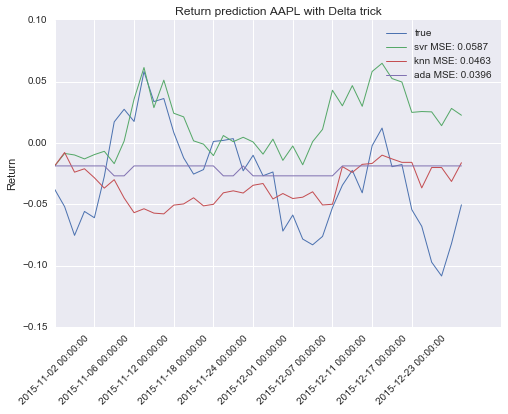

In [35]:
from IPython.display import Image
Image('Delta AAPL.png')

# Conclusion

### Domain Knowledge Expert

Feature engineering played a large part of this research. Some would say that this is the single most important part of using machine learning. With the help of trader friend I was iterating through different features based on what they look on a day to day basis. No doubt that working closely with an expert in the field would help the feature engineering part.

### Problem Definition

The problem could have been formulated differently. Instead of trying to predict the return over a period of time, 7 days in this case, and treating it as a regression problem it could be done as a classification problem where we just try to predict if the stock is gonna go up or down. By the very nature of stock trading the price is very volatile and quite unpredictable. Reducing it to a classification problem could simplify the problem.

As briefly mention, stock prices are volatile. Another thing that could be done to remove part of that volatility is to try to predict what the moving average would be. The label would be much smoother this way and large variations would occur less often.

### Model of choice

One would instinctively chose SVR because it fits the curve much better than kNN, regardless of the RMSE. But kNN has an intrinsic property of giving the volatility of the predictions. The standard deviation of the k points could represent our uncertainty about our own predictions. This is a huge comforting advantage to the user to get a confidence measure because in the end a human will make the decision to buy or sell a stock.

### Delta

Using the $\delta$ trick is bringing the RMSE much closer to my goal of 5%. I have never seen that in any blog post or paper and it makes it really hard to know if it has any foundation at all. But it does make sense to start from the previous day where we can assume we know the actual true return.